In [59]:
import pandas as pd
import numpy as np
from sklearn import linear_model 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import preprocessing
import seaborn as sn
import matplotlib.pyplot as plt
import missingno as mno


In [18]:
clevelandData = pd.read_csv("processed.cleveland.data", sep =",", header= None, na_values=["?"])
switzerlandData = pd.read_csv("processed.switzerland.data", sep= ",", header= None, na_values=["?"])
longbeachData = pd.read_csv("processed.va.data", sep = "," , header=None, na_values=["?"])
hungarianData = pd.read_csv("reprocessed.hungarian.data", sep = " " , header=None, na_values=["?"])
data = pd.concat([clevelandData, switzerlandData, longbeachData, hungarianData])
data.columns = ["age", "sex", "cp", "trestbps", "chol", "fbs" , "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "prediction"]

In [57]:
data = data.dropna(axis= 0, subset=["prediction"])
data.isnull().sum()/len(data)
data[["age", "sex","cp", "restecg","thalach", "slope", "ca" , "thal"]] = data[["age", "sex","cp", "restecg","thalach", "slope", "ca" , "thal"]].astype(int)
data[["fbs", "exang"]] = data[["fbs", "exang"]].astype(bool)
data.dtypes

data[data<0].count()
## mno.matrix(data, figsize=(20,6))


age             0
sex             0
cp              0
trestbps        1
chol           23
fbs             0
restecg         1
thalach         1
exang           0
oldpeak        12
slope         224
ca            424
thal          278
prediction      0
dtype: int64

In [58]:
nanImpute = SimpleImputer(missing_values=np.nan, strategy='mean')
dataval = nanImpute.fit_transform(data)

data = pd.DataFrame(dataval, columns=  ["age", "sex", "cp", "trestbps", "chol", "fbs" , "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "prediction"])


age             0
sex             0
cp              0
trestbps        1
chol           23
fbs             0
restecg         1
thalach         1
exang           0
oldpeak        12
slope         224
ca            424
thal          278
prediction      0
dtype: int64

In [83]:
data[data<0].count()
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
dataToScale = data [["age", "sex", "cp", "trestbps", "chol", "restecg", "thalach", "oldpeak", "slope", "ca", "thal"]]
normalizedValues = scaler.fit_transform(dataToScale)
normalizedData = pd.DataFrame(normalizedValues, columns= dataToScale.columns)
normalizedData = normalizedData.join(data[["fbs", "exang","prediction"]])


,cp,exang,slope,ca,thal,prediction
0,1.0,0.0,3.0,0.0,6.0,0.0
1,4.0,1.0,2.0,3.0,3.0,2.0
2,4.0,1.0,2.0,2.0,7.0,1.0
3,3.0,0.0,3.0,0.0,3.0,0.0
4,2.0,0.0,1.0,0.0,3.0,0.0
...,...,...,...,...,...,...
915,2.0,1.0,1.0,-9.0,-9.0,0.0
916,2.0,0.0,-9.0,-9.0,-9.0,0.0
917,3.0,0.0,-9.0,-9.0,6.0,0.0
918,2.0,0.0,1.0,-9.0,-9.0,0.0


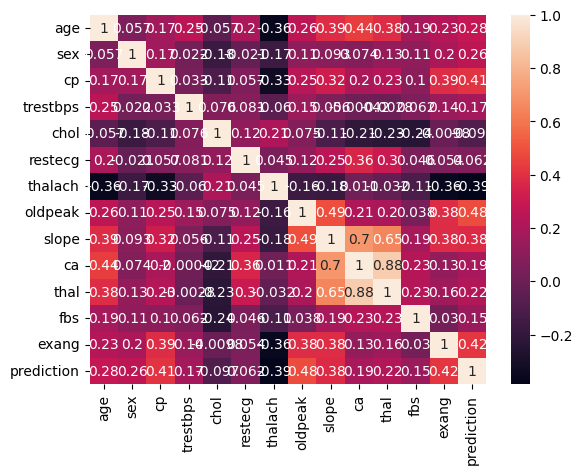

In [90]:
corrMatrix = normalizedData.corr()
sn.heatmap(corrMatrix, annot=True)

variables =  normalizedData.iloc[:,normalizedData.columns != "prediction"]
predictions = normalizedData["prediction"]  

selector = SelectKBest(chi2, k=5).fit(variables, predictions)

bestKSelected = selector.get_support(indices=True)
selectedData = data.iloc[:, bestKSelected]
selectedData.join([data[["prediction"]]])
